# Section1: work with data
**download SP500 stock prices**

In [52]:
import bs4 as bs
import requests
import yfinance as yf
import datetime
# use web scraper to get all sp500 indexes
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

tickers = [s.replace('\n', '') for s in tickers]
start = datetime.datetime(2016,1,1)
end = datetime.datetime(2020,7,26)

# download data
data = yf.download(tickers, start=start, end=end)
print(data)


            Adj Close                                                \
                    A        AAL         AAP        AAPL       ABBV   
Date                                                                  
2015-12-31        NaN        NaN         NaN         NaN        NaN   
2016-01-04  39.007351  39.095455  150.250793   97.948441  46.141216   
2016-01-05  38.873131  38.722763  149.224380   95.493919  45.948997   
2016-01-06  39.045681  39.401257  145.276642   93.625145  45.956993   
2016-01-07  37.387230  38.655853  146.885345   89.673714  45.820843   
...               ...        ...         ...         ...        ...   
2020-07-20  95.209999  11.470000  144.899994  393.429993  99.540001   
2020-07-21  96.019997  11.470000  147.380005  388.000000  97.400002   
2020-07-22  96.349998  11.360000  149.399994  389.089996  97.699997   
2020-07-23  96.660004  11.770000  148.369995  371.380005  98.029999   
2020-07-24  94.809998  11.390000  147.270004  370.459991  97.110001   

     

**data cleaning**

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def random_walk_with_outliers(origin, n_steps, perc_outliers=0.0, outlier_mult=10, seed=42):
    assert (perc_outliers >= 0.0) & (perc_outliers <= 1.0)
    #set seed for reproducibility
    np.random.seed(seed)
    
    # possible steps
    steps = [-1, 1]

    # simulate steps
    steps = np.random.choice(a=steps, size=n_steps-1)
    rw = np.append(origin, steps).cumsum(0)
    
    # add outliers
    n_outliers = int(np.round(perc_outliers * n_steps, 0))
    indices = np.random.randint(0, len(rw), n_outliers)
    rw[indices] = rw[indices] + steps[indices + 1] * outlier_mult
    return rw, indices



def hampel_filter(data2,columns, window_size=10, n_sigmas=3):
    data = data2.copy()
    # new hamper filter
    # https://towardsdatascience.com/outlier-detection-with-hampel-filter-85ddf523c73d
    for col in columns:
        new_series = data.loc[:,col]
        n = len(new_series)
        k = 1.4826 # scale factor for Gaussian distribution
        indices = []
        # possibly use np.nanmedian 
        for i in range((window_size),(n - window_size)):
            x0 = np.median(new_series[(i - window_size):(i + window_size)])
            S0 = k * np.median(np.abs(new_series[(i - window_size):(i + window_size)] - x0))
            if (np.abs(new_series[i] - x0) > n_sigmas * S0):
                new_series[i] = x0
                indices.append(i)
        data.loc[:,col] = new_series   
    return data


# for filling value in between
def linear_interpolation(data,columns):
    dataset = data.loc[:,columns]
    for ii,i in enumerate(dataset.index):
        for jj,j in enumerate(dataset):
            if str(dataset.iloc[ii,jj])=='nan':
                try:
                    if str(dataset.iloc[ii+1,jj])=='nan':
                        dataset.iloc[ii,jj]=dataset.iloc[ii-1,jj]
                    else:
                        dataset.iloc[ii,jj]=(dataset.iloc[ii-1,jj]+dataset.iloc[ii+1,jj])/2
                except:
                        dataset.iloc[ii,jj]=dataset.iloc[ii-1,jj]      
    data.update(dataset)
    return data

**Use hamper filter to remove the extreme movement to obtain a healthier beta as well as prevent data inaccuracy**

below is a little demonstration of how hamper filter detect extreme movement

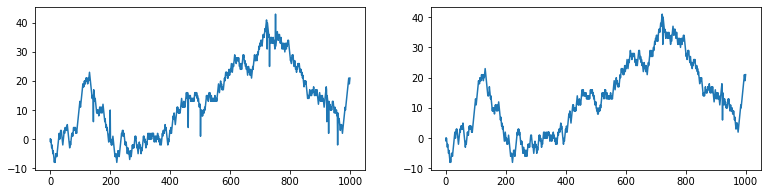

In [43]:
rw, outlier_ind = random_walk_with_outliers(0, 1000, 0.01)
rw2, outlier_ind2 = random_walk_with_outliers(0, 1000, 0.01)
df = pd.DataFrame(data={'Series1':rw,'Series2':rw2})
plt.figure(figsize=(13,3))
plt.subplot(1,2,1)
plt.plot(df.iloc[:,1])
df = hampel_filter(df,['Series1','Series2'])
plt.subplot(1,2,2)
plt.plot(df.iloc[:,1])
plt.show()

**First fill missing value**

In [61]:
all_stock_data = data.loc[:,'Close'].iloc[1:,:]
all_stock_data = all_stock_data.loc[:,all_stock_data.isna().sum()<10]
all_stock_data = linear_interpolation(all_stock_data,all_stock_data.columns)
all_stock_data.isna().sum().sum()
# because print zero, all value have been imputed

0

In [63]:
# need to take a few minutes
all_stock_data_cleaned = hampel_filter(all_stock_data,all_stock_data.columns)
all_stock_data_cleaned.to_csv('cleaned_sp500.csv')

# Section2: working with beta
**Now working with CAPM model with viriable risk free rate**

In [74]:
# use US base rate as risk free rate as this is the only publicly available rate time series. (Treasure bill rate is not available)
base_rate = pd.read_csv('US_base_rate.csv',index_col = 0)
base_rate.index = pd.DatetimeIndex(base_rate.index)
# convert to daily
base_rate = base_rate.reindex(pd.date_range(start = base_rate.index[0], end = base_rate.index[-1]))
for i in range(1,len(base_rate)):
    if base_rate.iloc[i,0]!=base_rate.iloc[i,0]:
        base_rate.iloc[i,0]=base_rate.iloc[i-1,0]
base_rate = all_stock_data_cleaned.join(base_rate,how='inner').iloc[:,[-1]]  # unify the time 

In [75]:
base_rate

,INTDSRUSM193N
2016-01-04,1.00
2016-01-05,1.00
2016-01-06,1.00
2016-01-07,1.00
2016-01-08,1.00
...,...
2020-04-27,0.25
2020-04-28,0.25
2020-04-29,0.25
2020-04-30,0.25


[*********************100%***********************]  1 of 1 completed


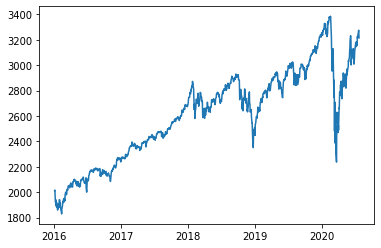

In [80]:
sp500 = yf.download(['^GSPC'], start=start, end=end)
plt.plot(sp500.loc[:,'Close'])

C:\Users\lunarhero\anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


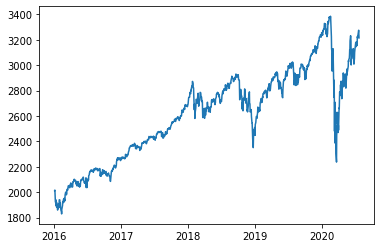

In [82]:
sp500 = linear_interpolation(sp500,sp500.columns)
sp500 = hampel_filter(sp500,sp500.columns)
plt.plot(sp500.loc[:,'Close'])

In [85]:
sp500.loc[:,'Close']

Date
2016-01-04    2012.660034
2016-01-05    2016.709961
2016-01-06    1990.260010
2016-01-07    1943.089966
2016-01-08    1922.030029
                 ...     
2020-07-20    3251.840088
2020-07-21    3257.300049
2020-07-22    3276.020020
2020-07-23    3235.659912
2020-07-24    3215.629883
Name: Close, Length: 1148, dtype: float64

In [485]:
all_stock_data_cleaned

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS,SP500
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,40.689999,40.910000,152.240005,105.349998,57.610001,101.870003,85.239998,42.930000,101.830002,91.970001,...,77.459999,58.860001,27.140974,36.080002,51.912292,101.809998,66.489998,26.709999,47.270000,2012.660034
2016-01-05,40.549999,40.520000,151.199997,102.709999,57.369999,103.360001,85.000000,42.919998,102.360001,92.339996,...,78.120003,60.060001,27.088274,36.070000,51.782890,103.930000,64.820000,26.420000,48.009998,2016.709961
2016-01-06,40.730000,41.230000,147.199997,100.699997,57.380001,101.779999,85.300003,42.560001,102.160004,91.019997,...,77.470001,59.189999,26.745718,35.619999,51.416248,104.379997,62.230000,25.650000,48.020000,1990.260010
2016-01-07,39.000000,40.450001,148.830002,96.449997,57.209999,98.529999,81.919998,41.540001,99.160004,89.110001,...,76.230003,58.669998,26.007906,34.700001,49.662113,101.980003,59.410000,24.879999,46.560001,1943.089966
2016-01-08,38.590000,40.369999,145.559998,96.959999,55.650002,97.959999,84.580002,40.669998,98.199997,87.849998,...,74.690002,56.990002,25.270092,34.369999,48.986340,101.550003,59.250000,24.600000,45.880001,1922.030029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-20,95.209999,11.470000,144.899994,393.429993,99.540001,102.190002,290.790009,99.080002,223.429993,455.269989,...,42.500000,43.480000,16.850000,74.169998,90.910004,130.679993,276.359985,32.020000,145.970001,3251.840088
2020-07-21,96.019997,11.470000,147.380005,388.000000,97.400002,104.150002,298.570007,98.190002,222.750000,444.279999,...,44.650002,43.840000,16.850000,74.430000,91.040001,132.529999,273.279999,33.740002,145.009995,3257.300049
2020-07-22,96.349998,11.360000,149.399994,389.089996,97.699997,103.809998,297.269989,100.190002,224.229996,445.049988,...,43.610001,44.070000,16.940001,74.419998,93.620003,133.089996,277.000000,33.279999,145.110001,3276.020020


In [344]:
all_stock_data_cleaned = pd.read_csv('cleaned_sp500.csv',index_col=0)
all_stock_data_cleaned = all_stock_data_cleaned.join(sp500.loc[:,'Close'],how='outer').rename(columns={'Close':'SP500'})
all_stock_data_cleaned = linear_interpolation(all_stock_data_cleaned,['SP500'])
all_stock_data_cleaned.isna().sum().sum()

0

In [345]:
all_stock_data_return = (all_stock_data_cleaned - all_stock_data_cleaned.shift(1))/all_stock_data_cleaned.shift(1)
all_stock_data_return = all_stock_data_return.iloc[1:,:]  # remove the first day
all_stock_data_return.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS,SP500
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,-0.003441,-0.009533,-0.006831,-0.025059,-0.004166,0.014626,-0.002816,-0.000233,0.005205,0.004023,...,0.008521,0.020387,-0.001942,-0.000277,-0.002493,0.020823,-0.025117,-0.010857,0.015655,0.002012
2016-01-06,0.004439,0.017522,-0.026455,-0.019570,0.000174,-0.015286,0.003529,-0.008388,-0.001954,-0.014295,...,-0.008321,-0.014486,-0.012646,-0.012476,-0.007080,0.004330,-0.039957,-0.029145,0.000208,-0.013115
2016-01-07,-0.042475,-0.018918,0.011073,-0.042205,-0.002963,-0.031932,-0.039625,-0.023966,-0.029366,-0.020984,...,-0.016006,-0.008785,-0.027586,-0.025828,-0.034116,-0.022993,-0.045316,-0.030020,-0.030404,-0.023700
2016-01-08,-0.010513,-0.001978,-0.021971,0.005288,-0.027268,-0.005785,0.032471,-0.020944,-0.009681,-0.014140,...,-0.020202,-0.028635,-0.028369,-0.009510,-0.013607,-0.004217,-0.002693,-0.011254,-0.014605,-0.010838
2016-01-11,-0.016844,0.017587,0.010236,0.016192,-0.031806,-0.039812,0.004966,0.001475,0.010489,0.017416,...,-0.013389,-0.019477,-0.019812,-0.008438,-0.001761,-0.017233,-0.006582,-0.019919,-0.028335,0.000853


In [177]:
years = (all_stock_data_cleaned.index[-1]-all_stock_data_cleaned.index[0]).days/365.25
idx = all_stock_data_return.iloc[:,-1]

rf = base_rate.iloc[:,0].mean()/100
rm = idx.mean()
x = np.linspace(0,2,50)
y = rf + x * (rm - rf)
portfolio = pd.DataFrame()
idx = all_stock_data_return.iloc[:,-1]
for ticker in all_stock_data_return.columns[:-1]:  # excluding SP500
    ri = all_stock_data_return.loc[:,ticker]
    beta = np.mean((ri - ri.mean()) * (idx - idx.mean())) / idx.std() ** 2
    x = beta
    y = ri.mean()
    if y > rf + x * (rm - rf):
        portfolio[ticker] = ri
    i+=1
portfolio

,A,AAL,AAPL,ACN,ADBE,ADI,ADP,ADSK,AES,AIG,...,WHR,WMB,WRK,WY,WYNN,XLNX,XRX,XYL,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,-0.003441,-0.009533,-0.025059,0.005205,0.004023,-0.007347,0.002437,0.001326,0.013786,0.003475,...,-0.021541,0.003430,-0.000659,0.002347,0.018904,0.014847,-0.001942,-0.000277,-0.025117,-0.010857
2016-01-06,0.004439,0.017522,-0.019570,-0.001954,-0.014295,-0.042561,-0.012277,-0.014075,-0.034519,-0.014677,...,-0.025535,-0.130270,-0.027698,-0.022074,-0.051805,-0.018287,-0.012646,-0.012476,-0.039957,-0.029145
2016-01-07,-0.042475,-0.018918,-0.042205,-0.029366,-0.020984,-0.025512,-0.030519,-0.059792,-0.024919,-0.023933,...,-0.025142,-0.100000,-0.009948,-0.036936,-0.094070,-0.039448,-0.027586,-0.025828,-0.045316,-0.030020
2016-01-08,-0.010513,-0.001978,0.005288,-0.009681,-0.014140,-0.008727,-0.008251,-0.016434,0.014444,-0.014918,...,-0.015183,-0.014556,-0.042475,-0.009233,-0.040704,-0.020534,-0.028369,-0.009510,-0.002693,-0.011254
2016-01-11,-0.016844,0.017587,0.016192,0.010489,0.017416,0.023809,0.004864,0.003088,-0.010953,0.004178,...,-0.008483,-0.079764,-0.051753,-0.010394,-0.016453,0.004426,-0.019812,-0.008438,-0.006582,-0.019919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-20,0.008901,-0.036944,0.021074,0.006713,0.052842,0.002655,-0.001016,0.035086,-0.023672,-0.022105,...,0.003507,-0.024279,-0.020020,-0.012331,-0.033712,0.025276,-0.028818,-0.001077,0.011937,-0.016585
2020-07-21,0.008507,0.000000,-0.013802,-0.003043,-0.024140,-0.021186,-0.002374,-0.025809,0.010485,0.017510,...,0.004893,0.042509,0.011917,0.001951,-0.009754,-0.008541,0.000000,0.003505,-0.011145,0.053716
2020-07-22,0.003437,-0.009590,0.002809,0.006644,0.001733,-0.006109,0.003943,0.004381,0.011673,0.007196,...,0.021772,-0.032819,0.004711,0.016745,-0.039020,0.008811,0.005341,-0.000134,0.013612,-0.013634


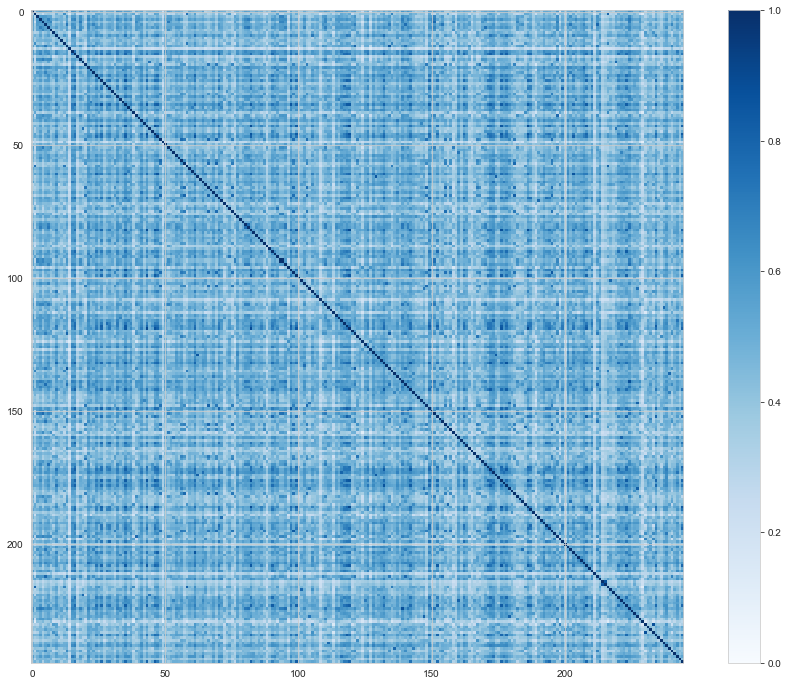

In [178]:
import seaborn as sns
plt.figure(figsize=(16, 12))
plt.imshow(portfolio.corr(), cmap='Blues', vmin = 0.0, vmax = 1)
plt.colorbar()

In [356]:
my_portfolio_list = pd.DataFrame()
stock_mean = pd.DataFrame()
corr = portfolio.corr()
for stock in portfolio.columns:
    stock_mean.at[0,stock] = portfolio[stock].mean()
stock_mean = stock_mean.sort_values(0,ascending=False,axis = 1)
number = 0
for stock in stock_mean.columns:
    if number == 0:
        my_portfolio_list.at[0,stock] = stock_mean.at[0,stock]
        number += 1
        last = stock
    else:
        if corr.at[stock,last]>0.33 or stock_mean.at[0,stock]<0:
            pass
        else:
            my_portfolio_list.at[0,stock] = stock_mean.at[0,stock]
            last = stock
my_portfolio_list

,AMD,PYPL,NRG,AAPL,WMB,CTSH,FANG,LUV
0,0.003618,0.001612,0.001267,0.00125,0.000248,0.000241,0.000183,0.000015


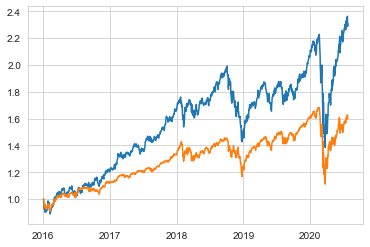

In [357]:
return_1 = all_stock_data_cleaned.loc[:,my_portfolio_list.columns].sum(axis=1)
return_1 = return_1/return_1[0]
idx_return = all_stock_data_cleaned.iloc[:,-1]/all_stock_data_cleaned.iloc[0,-1]
plt.plot(return_1)
plt.plot(idx_return)


# Section3: momentum factor

I only work with momentum factor as I cannot find open source dataset for company financials to build Fama-French model or quality, size factors

In [359]:
# construct momentum sentiment for each stock
from scipy.stats import linregress
def momentum(closes):
    returns = np.log(closes)
    x = np.arange(len(returns))
    slope, _, rvalue, _, _ = linregress(x, returns)
    return ((1 + slope) ** 252) * (rvalue ** 2)  # annualize slope and multiply by R^2

momentums = all_stock_data_cleaned.iloc[:,:-1].copy()
for ticker in all_stock_data_cleaned.columns[:-1]:
    momentums[ticker] = all_stock_data_cleaned[ticker].rolling(90).apply(momentum, raw=False)
    
    
y = alpha + beta*move_averaged_return

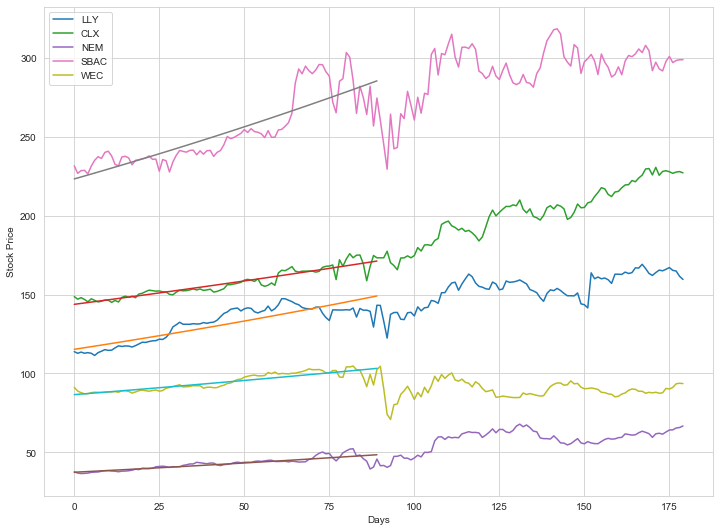

In [407]:
# visualise the momentum result
plt.figure(figsize=(12, 9))
plt.xlabel('Days')
plt.ylabel('Stock Price')

bests = momentums.iloc[-90,:].sort_values(ascending=False).index[:5]
end = len(all_stock_data_cleaned)-90
for best in bests:
    rets = np.log(all_stock_data_cleaned[best].iloc[end - 90 : end])
    x = np.arange(len(rets))
    slope, intercept, r_value, p_value, std_err = linregress(x, rets)
    plt.plot(np.arange(180), all_stock_data_cleaned[best][end-90:end+90],label=best)
    plt.plot(x, np.e ** (intercept + slope*x))
    
plt.legend()

**backtesting on momentum**
based on a strategy where update portfolio every 10 days, to match the requirement of this assessment

In [371]:
# start backtesting with equal shares strategy
profit = [100]
index_profit = [100]
dates = [momentums.index[90]]

for i in range(90,1150,10):
    bests = momentums.iloc[i,:].sort_values(ascending=False).index[:10]
    bests = [i for i in bests if i != 'SP500']
    start = momentums.index[i]
    end = momentums.index[i+10]
    return_1 = (all_stock_data_cleaned.loc[end,my_portfolio_list.columns].sum() - all_stock_data_cleaned.loc[start,my_portfolio_list.columns].sum())/all_stock_data_cleaned.loc[start,my_portfolio_list.columns].sum()
    return_2 = (all_stock_data_cleaned.loc[end,'SP500'] - all_stock_data_cleaned.loc[start,'SP500'])/all_stock_data_cleaned.loc[start,'SP500']
    profit+= [profit[-1]*(return_1+1)]
    index_profit+= [index_profit[-1]*(return_2+1)]
    dates+=[end]

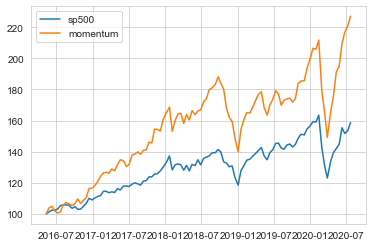

In [372]:
plt.plot(dates,index_profit,label='sp500')
plt.plot(dates,profit,label='momentum')
plt.legend()

In [408]:
# start backtesting with equal value strategy
profit = [100]
index_profit = [100]
dates = [momentums.index[90]]

for i in range(90,1150,10):
    bests = momentums.iloc[i,:].sort_values(ascending=False).index[:10]
    bests = [i for i in bests if i != 'SP500']
    start = momentums.index[i]
    end = momentums.index[i+10]
    
    return_1 = (all_stock_data_cleaned.loc[end,my_portfolio_list.columns] - all_stock_data_cleaned.loc[start,my_portfolio_list.columns])/all_stock_data_cleaned.loc[start,my_portfolio_list.columns]
    return_1 = return_1.mean()
    return_2 = (all_stock_data_cleaned.loc[end,'SP500'] - all_stock_data_cleaned.loc[start,'SP500'])/all_stock_data_cleaned.loc[start,'SP500']
    profit+= [profit[-1]*(return_1+1)]
    index_profit+= [index_profit[-1]*(return_2+1)]
    dates+=[end]

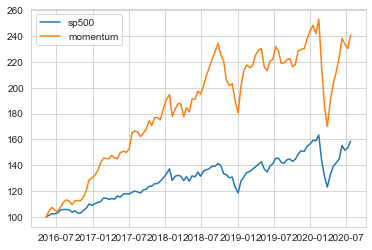

In [409]:
plt.plot(dates,index_profit,label='sp500')
plt.plot(dates,profit,label='momentum')
plt.legend()

In [412]:
my_portfolio_list

,AMD,PYPL,NRG,AAPL,WMB,CTSH,FANG,LUV
0,0.003618,0.001612,0.001267,0.00125,0.000248,0.000241,0.000183,0.000015


# Section 4: performance of the portfolio

In [315]:
import pandas as pd
import numpy as np


def annualized_return(x):
    '''Compute Annaulzied Return'''
    gross_return = x.iloc[-1]/x.iloc[0]
    shape = x.shape
    days = shape[0]
    years = days/252
    ann_return = gross_return ** (1/years)
    ann_return = ann_return - 1
    df = pd.DataFrame({'Portfolio':ann_return.index, \
                       'Annualized Return':ann_return.values})
    return df

def annualized_standard_deviation(x):
    '''Compute Annualized Standard Deviation'''
    data2 = x.pct_change()
    std = data2.std() * 252 ** 0.5
    df = pd.DataFrame({'Portfolio':std.index, 'Standard Deviation':std.values})
    return df

def max_drawdown(x):
    '''Max Peak to Trough Loss'''
    roll_max = x.expanding().max()
    daily_drawdown = x/roll_max - 1.0
    # Next we calculate the minimum (negative) daily drawdown in that window.
    # Again, use min_periods=1 if you want to allow the expanding window
    max_daily_drawdown = daily_drawdown.expanding().min()
    # Plot the results
    #Daily_Drawdown.plot()
    #Max_Daily_Drawdown.plot()
    max_dd = np.min(max_daily_drawdown)
    max_dd = pd.DataFrame({'Portfolio':max_dd.index, \
                                 'Max Drawdown':max_dd.values})
    return max_dd

def gain_to_pain_ratio(x):
    '''Calculate Schwager's Gain to Pain Ratio'''
    returns = x.pct_change().dropna()
    positive_returns = returns[returns >= 0].sum()
    negative_returns = abs(returns[returns < 0].sum())
    gain_to_pain = positive_returns / negative_returns
    gain_to_pain = pd.DataFrame({'Portfolio':gain_to_pain.index, \
                                 'Gain to Pain Ratio':gain_to_pain.values})
    return gain_to_pain

def calmar_ratio(x):
    '''Annualized Return over Max Drawdown'''
    calmar = annualized_return(x).iloc[:, 1]/-max_drawdown(x).iloc[:, 1]
    calmar = pd.DataFrame({'Portfolio':x.columns, 'Calmar Ratio':calmar.values})
    return calmar

def sharpe_ratio(x, RF=0):
    '''Annualized Return - RF rate / Standand Deviation'''
    returns = annualized_return(x)
    std = annualized_standard_deviation(x)
    data = returns.merge(std)
    data['Sharpe Ratio (RF = ' + str(RF) + ')'] = \
        (data['Annualized Return']-float(RF))/data['Standard Deviation']
    sharpe = data[['Portfolio', 'Sharpe Ratio (RF = ' + str(RF) + ')']]
    return sharpe

def sortino_ratio(x, RF=0):
    '''Similar to Sharpe Ratio but denominator is Std Dev. of downside vol'''
    returns = annualized_return(x)
    RF_daily = RF/252
    returns_data = x.pct_change().dropna()
    downside_excess_returns = returns_data[(returns_data - RF_daily) > 0]
    std = downside_excess_returns.std() * 252 ** 0.5
    df = pd.DataFrame({'Portfolio':std.index, 'Downside Standard Deviation':std.values})
    data = returns.merge(df)
    data['Sortino Ratio (RF = ' + str(RF) + ')'] = \
        (data['Annualized Return']-float(RF))/data['Downside Standard Deviation']
    sortino = data[['Portfolio', 'Sortino Ratio (RF = ' + str(RF) + ')']]
    return sortino

In [437]:
bests = momentums.iloc[-1,:].sort_values(ascending=False).index[:10]
final_portfolio = list(set(list(my_portfolio_list.columns)+list(bests)))
final_portfolio= [i for i in final_portfolio if i not in ['HAL','APA','ABMD','FCX']]
final_portfolio = all_stock_data_cleaned.loc[:,final_portfolio]
final_portfolio.loc[:,'Total'] = final_portfolio.sum(axis=1)

In [439]:
print(annualized_return(final_portfolio))
print(gain_to_pain_ratio(final_portfolio))
print(calmar_ratio(final_portfolio))
print(sharpe_ratio(final_portfolio,rf))
print(sortino_ratio(final_portfolio,rf))

   Portfolio  Annualized Return
0       FANG          -0.100450
1       EBAY           0.174268
2       ALGN           0.398464
3       AAPL           0.316307
4        LUV          -0.059704
5       TSCO           0.130049
6       PYPL           0.419432
7        LOW           0.157554
8        LEN           0.095755
9       CTSH           0.013470
10       WMB          -0.065888
11       AMD           1.021806
12       NRG           0.268165
13     Total           0.206490
   Portfolio  Gain to Pain Ratio
0       FANG            1.017837
1       EBAY            1.147618
2       ALGN            1.215326
3       AAPL            1.242392
4        LUV            1.002042
5       TSCO            1.110526
6       PYPL            1.261969
7        LOW            1.138912
8        LEN            1.090487
9       CTSH            1.041611
10       WMB            1.029051
11       AMD            1.305221
12       NRG            1.162414
13     Total            1.196223
   Portfolio  Calmar Rati

In [415]:
final_portfolio.columns

Index(['FANG', 'HAL', 'APA', 'EBAY', 'ALGN', 'AAPL', 'LUV', 'TSCO', 'PYPL',
       'ABMD', 'LOW', 'LEN', 'CTSH', 'WMB', 'AMD', 'FCX', 'NRG', 'Total'],
      dtype='object')

**Below shows thge reason why I did not use the api**
And the api did not provide addtional information other than the historical price

In [482]:
import socket
import ssl
import json

host = 'xapia.x-station.eu'
port = 5124
USERID = 11325034
PASSWORD = .....

host = socket.getaddrinfo(host, port)[0][4][0]

s = socket.socket()
s.connect((host, port))
s = ssl.wrap_socket(s)

parameters = {
    "command" : "login",
    "arguments" : {
        "userId": USERID,
        "password": PASSWORD
    }
}
packet = json.dumps(parameters, indent=4)
s.send(packet.encode("UTF-8"))
END = b'\n\n'
response = s.recv(1000000)
if END in response:
    print('Print login: {}'.format(response[:response.find(END)]))

parameters = {
	"command":"getAllSymbols"
}


packet = json.dumps(parameters, indent=4)
s.send(packet.encode("UTF-8"))

response = s.recv(1000000)
if END in response:
    print('Print logout: {}'.format(response[:response.find(END)]))




Print login: b'{"status":true,"streamSessionId":"5cf3fcfffe781238-00005379-00091faa-e3a78401eee242aa-a41ecea3"}'


In [484]:
print(len(response.decode('utf-8')))
response.decode('utf-8')
# you could see that the returned reponse has a limit


13680


'{"status":true,"returnData":[{"symbol":"CRH.UK_4","currency":"GBP","categoryName":"STC","currencyProfit":"GBP","quoteId":6,"quoteIdCross":4,"marginMode":103,"profitMode":6,"pipsPrecision":3,"contractSize":1,"exemode":1,"time":1596037497567,"expiration":null,"stopsLevel":0,"precision":3,"swapType":2,"stepRuleId":225,"type":14,"instantMaxVolume":2147483647,"groupName":"UK","description":"CRH PLC CFD","longOnly":false,"trailingEnabled":false,"marginHedgedStrong":false,"swapEnable":true,"percentage":100.0,"bid":28.920,"ask":28.950,"high":29.350,"low":28.700,"lotMin":1.00,"lotMax":1000000.00,"lotStep":1.00,"tickSize":0.001,"tickValue":0.001,"swapLong":-2.56475,"swapShort":-2.43525,"leverage":20.00,"spreadRaw":0.030,"spreadTable":30.0,"starting":null,"swap_rollover3days":0,"marginMaintenance":0,"marginHedged":0,"initialMargin":0,"currencyPair":false,"shortSelling":true,"timeString":"Wed Jul 29 17:44:57 CEST 2020"},{"symbol":"GBPCHF","currency":"GBP","categoryName":"FX","currencyProfit":"CHF

# Performance Tracker:

### day 2 performance: (30/07/2020)
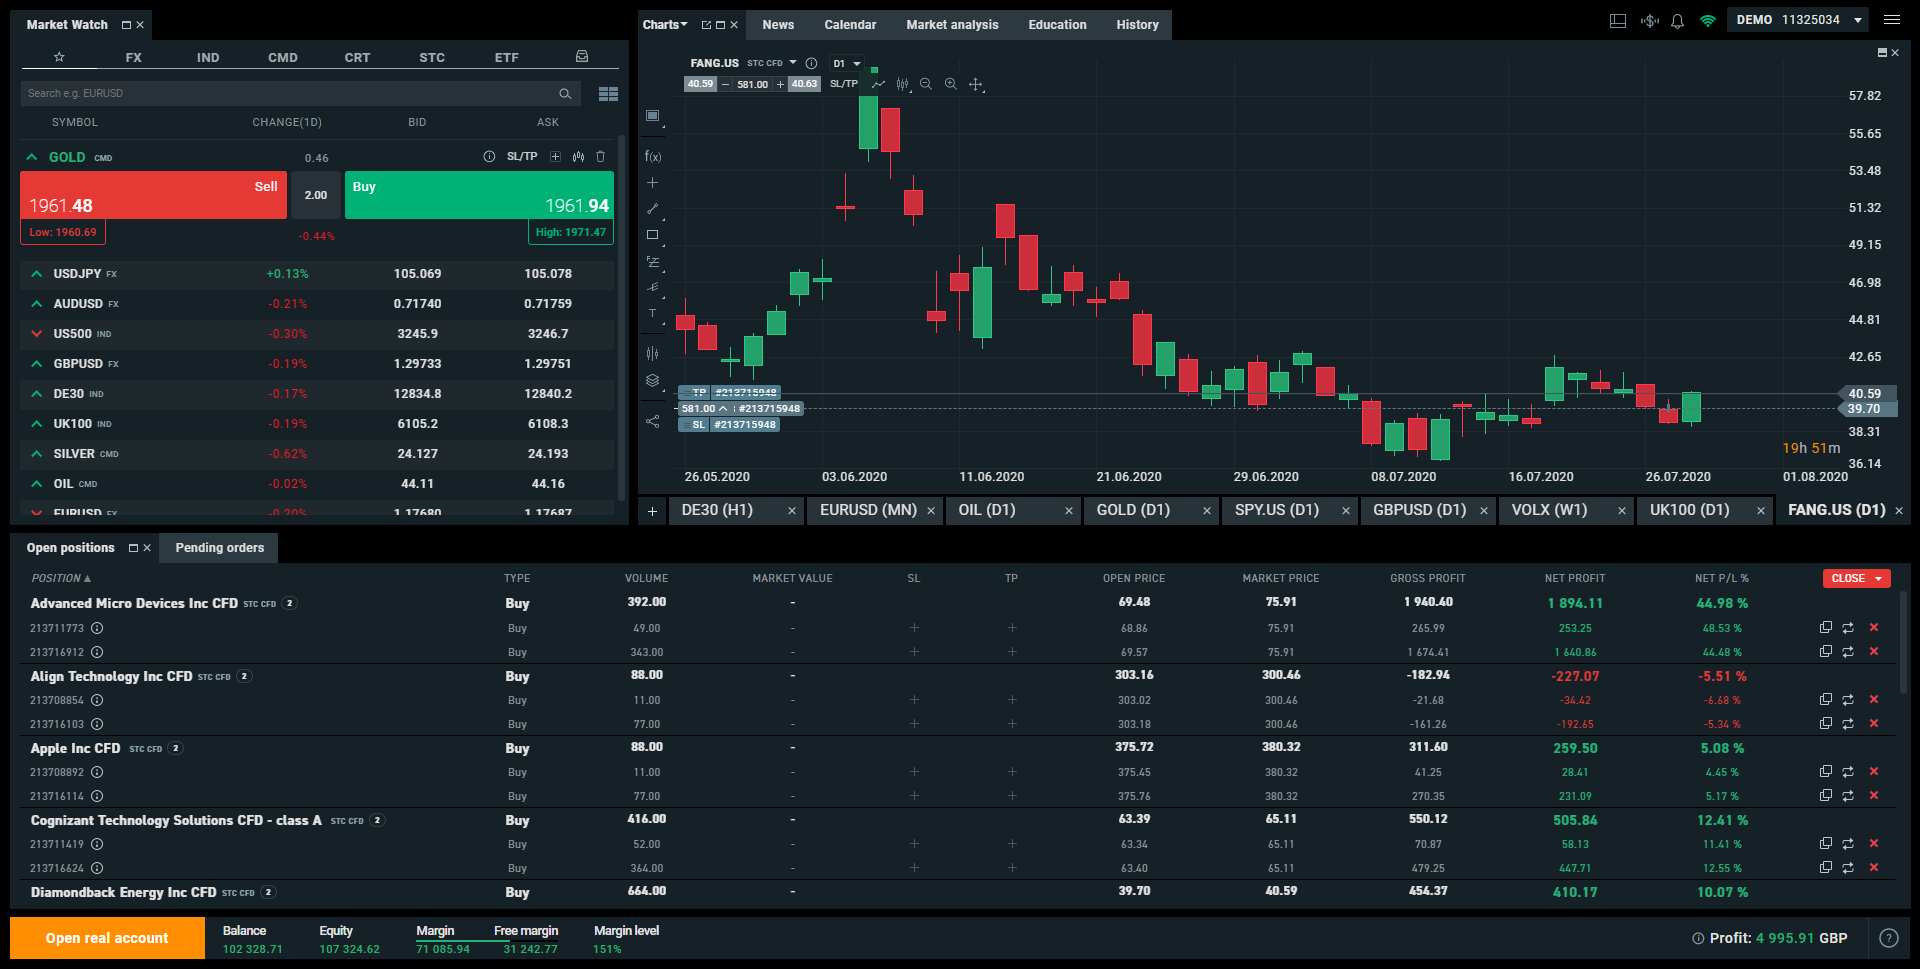